# NHS KPI Categorisation & Simulation Project


In [1]:
# Import necessary libraries
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warning messages for cleaner output
warnings.filterwarnings("ignore")

### Step 1: Load KPI Data
B begin by loading the core dataset containing ward-level KPI values. Each row represents a monthly measurement for a specific KPI in a given ward.  
The goal is to later classify these values into performance categories (Gold, Silver, etc.) based on standard thresholds.

**Columns overview**:
- `Ward`: Name of the unit or ward  
- `KPI_Name`: The specific key performance indicator  
- `Year` and `Month`: Time period of the KPI recording  
- `KPI_Value`: The recorded value, which may be a percenumber or text or score


In [2]:
# Load KPI data
kpi_data = pd.read_csv("KPI_Data_2024.csv")
print("KPI Data Sample:")
display(kpi_data.head())

KPI Data Sample:


,Ward,KPI_Name,Year,Month,KPI_Value
0,Stroke Unit,Hand Hygiene Compliance,2024,Jan,88.6
1,Stroke Unit,Hand Hygiene Compliance,2024,Feb,99.7
2,Stroke Unit,Hand Hygiene Compliance,2024,Mar,95.9
3,Stroke Unit,Hand Hygiene Compliance,2024,Apr,85.1
4,Stroke Unit,Hand Hygiene Compliance,2024,May,95.8


### Step 2: Load KPI Thresholds

Now load a reference table that defines performance thresholds for each KPI.  
These thresholds determine what constitutes "Gold", "Silver", "Bronze", etc., and the expected direction (high/low). Some KPIs are flagged as "manual" and will be excluded from logic-based classification.

**Columns include**:
- `KPI_Name`: Matching key with the KPI data
- `Direction`: Whether higher or lower values are better
-  Thresholds for each category band
- `Manual_Flag`: Indicates if manual review is needed

In [3]:
# Load Thresholds data
thresholds = pd.read_csv("KPI_Threshold_Lookup_Table.csv")

print("\nThreshold Table Sample:")
display(thresholds.head())


Threshold Table Sample:


,KPI_Name,Direction,Gold_Threshold,Silver_Max,Silver_Min,Bronze_Max,Bronze_Min,Manual_Flag
0,Hand Hygiene Compliance,high,95.0,94.0,90.0,89.0,85.0,No
1,Falls per 1000 Bed Days,low,0.0,1.9,3.3,3.4,4.5,No
2,Record Keeping Compliance,high,95.0,94.0,90.0,89.0,85.0,No
3,Violence and Aggression Incidents,low,0.0,5.0,15.0,16.0,25.0,No
4,Concerns Logged,manual,NaN,NaN,NaN,NaN,NaN,Yes


### Step 3: Inspect KPI Data Types and Value Format

Before applying classification logic, it's important to ensure the `KPI_Value` column contains valid numeric entries.  
Threshold comparisons rely on numerical values, and mixed or invalid formats may lead to incorrect categorisation.

- The data types of each column are reviewed to confirm structural consistency.
- Any non-numeric entries in `KPI_Value` are identified and displayed for further attetion.
view.


In [4]:
# Check data types of KPI data
display(kpi_data.dtypes)

print("-----------------------------")
# Identify non-numeric entries in KPI_Value column
non_numeric_rows = kpi_data[~kpi_data['KPI_Value'].apply(lambda x: pd.to_numeric(x, errors='coerce')).notnull()]

print(non_numeric_rows)

Ward          object
KPI_Name      object
Year           int64
Month         object
KPI_Value    float64
dtype: object

-----------------------------
Empty DataFrame
Columns: [Ward, KPI_Name, Year, Month, KPI_Value]
Index: []


### Step 4: Confirm KPI Name Consistency and Merge Datasets

Before merging the KPI data with the threshold lookup table, it's useful to confirm that all `KPI_Name` values match correctly between both sources.  
This avoids join issues and ensures each KPI receives the appropriate threshold logic.

- A left join is used to retain all rows from the main dataset.
- The merged dataset includes additional columns such as `Direction`, thresholds for each category, and the manualflag.


In [5]:
# Display unique KPI names from both datasets to verify alignment
print("Unique KPI Names in KPI Data:")
print(kpi_data['KPI_Name'].unique())

print("\nUnique KPI Names in Threshold Table:")
print(thresholds['KPI_Name'].unique())

# Merge KPI data with thresholds using KPI name
merged_data = pd.merge(kpi_data, thresholds, on='KPI_Name', how='left')

print("\nMerged Data Sample:")
display(merged_data.head())

Unique KPI Names in KPI Data:
['Hand Hygiene Compliance' 'Falls per 1000 Bed Days'
 'Record Keeping Compliance' 'Violence and Aggression Incidents'
 'Concerns Logged']

Unique KPI Names in Threshold Table:
['Hand Hygiene Compliance' 'Falls per 1000 Bed Days'
 'Record Keeping Compliance' 'Violence and Aggression Incidents'
 'Concerns Logged']

Merged Data Sample:


,Ward,KPI_Name,Year,Month,KPI_Value,Direction,Gold_Threshold,Silver_Max,Silver_Min,Bronze_Max,Bronze_Min,Manual_Flag
0,Stroke Unit,Hand Hygiene Compliance,2024,Jan,88.6,high,95.0,94.0,90.0,89.0,85.0,No
1,Stroke Unit,Hand Hygiene Compliance,2024,Feb,99.7,high,95.0,94.0,90.0,89.0,85.0,No
2,Stroke Unit,Hand Hygiene Compliance,2024,Mar,95.9,high,95.0,94.0,90.0,89.0,85.0,No
3,Stroke Unit,Hand Hygiene Compliance,2024,Apr,85.1,high,95.0,94.0,90.0,89.0,85.0,No
4,Stroke Unit,Hand Hygiene Compliance,2024,May,95.8,high,95.0,94.0,90.0,89.0,85.0,No


### Step 5: Validate Merge – Check for Missing Thresholds

After merging, it's important to confirm that all `KPI_Name` values were successfully matched with a threshold definition.  
This check filters for any rows where `Direction` is missing, indicating an unmatched or undefined KPI.

An empty result confirms that all KPIs in the dataset have corresponding threshold logic availble.


In [6]:
# Identify any KPI records that did not match a threshold (missing direction)
missing_thresholds = merged_data[merged_data['Direction'].isnull()]

print("\nRows with missing threshold match:")
print(missing_thresholds)


Rows with missing threshold match:
Empty DataFrame
Columns: [Ward, KPI_Name, Year, Month, KPI_Value, Direction, Gold_Threshold, Silver_Max, Silver_Min, Bronze_Max, Bronze_Min, Manual_Flag]
Index: []


### Step 6: Define Categorisation Logic

This function assigns each KPI record to a performance category based on predefined thresholds.

- If a KPI is flagged as "Manual", it is assigned that category directly.
- If `Direction` is "high", higher values are better.
- If `Direction` is "low", lower values are better.
- Values falling outside all threshold ranges are marked as "White" (unclassfied).


In [7]:
def assign_category(row):
    # Handle manual flag first
    if row['Manual_Flag'] == "Yes":
        return "Manual"
    
    value = row['KPI_Value']
    
    # High direction: higher values are better
    if row['Direction'] == "high":
        if value >= row['Gold_Threshold']:
            return "Gold"
        elif row['Silver_Min'] <= value <= row['Silver_Max']:
            return "Silver"
        elif row['Bronze_Min'] <= value <= row['Bronze_Max']:
            return "Bronze"
        else:
            return "White"
    
    # Low direction: lower values are better
    elif row['Direction'] == "low":
        if value <= row['Gold_Threshold']:
            return "Gold"
        elif row['Silver_Min'] <= value <= row['Silver_Max']:
            return "Silver"
        elif row['Bronze_Min'] <= value <= row['Bronze_Max']:
            return "Bronze"
        else:
            return "White"

    # Fallback if direction is not specified
    return "White"

### Step 7: Apply Categorisation Logic to KPI Records

The `assign_category` function is applied row-wise to the merged dataset to assign a performance category to each KPI entry.  
This results in a new column called `Assigned_Category`.

The table below shows the first 10 categorised rows for validation.

In [8]:
# Apply categorisation logic to each row
merged_data['Assigned_Category'] = merged_data.apply(assign_category, axis=1)

# Preview categorised results
print("Categorised Sample:")
display(merged_data[['Ward', 'KPI_Name', 'Month', 'KPI_Value', 'Assigned_Category']].head(10))

Categorised Sample:


,Ward,KPI_Name,Month,KPI_Value,Assigned_Category
0,Stroke Unit,Hand Hygiene Compliance,Jan,88.6,Bronze
1,Stroke Unit,Hand Hygiene Compliance,Feb,99.7,Gold
2,Stroke Unit,Hand Hygiene Compliance,Mar,95.9,Gold
3,Stroke Unit,Hand Hygiene Compliance,Apr,85.1,Bronze
4,Stroke Unit,Hand Hygiene Compliance,May,95.8,Gold
5,Stroke Unit,Hand Hygiene Compliance,Jun,97.7,Gold
6,Stroke Unit,Hand Hygiene Compliance,Jul,93.8,Silver
7,Stroke Unit,Hand Hygiene Compliance,Aug,100.0,Gold
8,Stroke Unit,Hand Hygiene Compliance,Sep,87.9,Bronze
9,Stroke Unit,Hand Hygiene Compliance,Oct,85.2,Bronze


### Step 8: Generate Category Counts by Ward and Month

This summary table shows the number of KPIs assigned to each category (Gold, Silver, Bronze, etc.) for every ward and month.  
It provides a quick overview of overall performance distribution at the ward levl.


In [9]:
# Count number of KPIs in each category for each Ward-Month combination
category_counts = merged_data.groupby(['Ward', 'Month', 'Assigned_Category']).size().unstack(fill_value=0).reset_index()

print("Category counts per Ward + Month:")
display(category_counts.head())

Category counts per Ward + Month:


Assigned_Category,Ward,Month,Bronze,Gold,Manual,Silver,White
0,Emergency Assessment Unit [EAU],Apr,0,1,1,1,2
1,Emergency Assessment Unit [EAU],Aug,1,1,1,0,2
2,Emergency Assessment Unit [EAU],Dec,1,1,1,0,2
3,Emergency Assessment Unit [EAU],Feb,0,2,1,0,2
4,Emergency Assessment Unit [EAU],Jan,1,1,1,0,2


### Step 9: Calculate Category Distribution as Percentages

To assess overall annual performance, the total count of each KPI category is summed for each ward across all months.  
These totals are then converted into percentages to represent the distribution of KPI outcomes per ward.

This helps quickly identify which wards perform consistently well (e.g. higher % Gold) or may need support (e.g. higher % White or Manual).

In [10]:
# Step 1: Sum all category counts by ward (across all months)
ward_summary = category_counts.groupby('Ward')[['Gold', 'Silver', 'Bronze', 'Manual', 'White']].sum()

# Step 2: Convert to percentage distribution per ward
ward_percent = ward_summary.div(ward_summary.sum(axis=1), axis=0) * 100
ward_percent = ward_percent.round(0).astype(int)

# Preview the percentage table
print("Category % by Ward (Annual Summary):")
display(ward_percent.head())

Category % by Ward (Annual Summary):


Assigned_Category,Gold,Silver,Bronze,Manual,White
Ward,,,,,
Emergency Assessment Unit [EAU],18,10,8,20,43
Short Stay Unit [SSU],8,15,13,20,43
Stroke Unit,15,10,15,20,40
Ward 11,13,10,10,20,47
Ward 12,17,12,10,20,42


### Step 10: Add Total KPI Count and Gold Percentage per Ward-Month

This step calculates:
- The total number of KPIs recorded per ward per month (`Total_KPIs`)
- The percentage of those KPIs that achieved a "Gold" rating (`Gold_Percentage`)

This provides a quick metric to assess overall monthly performance strength at the ward evel.


In [11]:
# Add total KPI count across categories for each row
category_counts['Total_KPIs'] = category_counts[['Gold', 'Silver', 'Bronze', 'Manual', 'White']].sum(axis=1)

# Calculate the percentage of Gold-rated KPIs
category_counts['Gold_Percentage'] = (category_counts['Gold'] / category_counts['Total_KPIs']) * 100

# Preview the updated summary
print("\nAdded % Gold column:")
display(category_counts[['Ward', 'Month', 'Gold', 'Total_KPIs', 'Gold_Percentage']].head())


Added % Gold column:


Assigned_Category,Ward,Month,Gold,Total_KPIs,Gold_Percentage
0,Emergency Assessment Unit [EAU],Apr,1,5,20.0
1,Emergency Assessment Unit [EAU],Aug,1,5,20.0
2,Emergency Assessment Unit [EAU],Dec,1,5,20.0
3,Emergency Assessment Unit [EAU],Feb,2,5,40.0
4,Emergency Assessment Unit [EAU],Jan,1,5,20.0


### Step 11: Assign Performance Ratings Based on Gold Percentage

A final performance rating is assigned to each ward-month based on the percentage of KPIs rated as "Gold".  
This provides a quick, qualitative summary of monthly performance levels:

- **≥ 90%** → Excellent  
- **70–89%** → Good  
- **50–69%** → Needs Improvement  
- **< 50%** → Needs Atention
tention


In [12]:
# Step 3: Define performance based on % Gold
def overall_performance(pct):
    if pct >= 90:
        return "Excellent"
    elif pct >= 70:
        return "Good"
    elif pct >= 50:
        return "Needs Improvement"
    else:
        return "needs attention"

category_counts['Overall_Performance'] = category_counts['Gold_Percentage'].apply(overall_performance)

print("\nFinal Summary Table:")
display(category_counts[['Ward', 'Month', 'Gold_Percentage', 'Overall_Performance']].head())


Final Summary Table:


Assigned_Category,Ward,Month,Gold_Percentage,Overall_Performance
0,Emergency Assessment Unit [EAU],Apr,20.0,needs attention
1,Emergency Assessment Unit [EAU],Aug,20.0,needs attention
2,Emergency Assessment Unit [EAU],Dec,20.0,needs attention
3,Emergency Assessment Unit [EAU],Feb,40.0,needs attention
4,Emergency Assessment Unit [EAU],Jan,20.0,needs attention


##  Simulation 1: Stricter Gold Threshold for High-Value KPIs

This simulation explores how performance categorisation would change if the Gold standard were raised from its original value to **97** for KPIs where higher values are better.

**Purpose**:
- Assess the impact of stricter policy on reported performance
- Identify KPIs or months that would lose Gold status under tougher criteria
- Support decision-makers in understanding the sensitivity of current performance levels

Only KPIs with `Direction = "high"` are affected  by thi change.


In [13]:
# Create a copy of the merged dataset for simulation
simulated_data = merged_data.copy()

# Tighten the Gold threshold for KPIs where higher values are better
simulated_data.loc[simulated_data['Direction'] == 'high', 'Gold_Threshold'] = 97

# Re-apply categorisation logic with new threshold
simulated_data['Simulated_Category'] = simulated_data.apply(assign_category, axis=1)

# Compare original vs simulated categories
comparison = simulated_data[['Ward', 'KPI_Name', 'Month', 'KPI_Value', 'Assigned_Category', 'Simulated_Category']]
comparison['Changed'] = comparison['Assigned_Category'] != comparison['Simulated_Category']

# Display sample results
print("Sample Simulation Comparison:")
display(comparison.head(10))

Sample Simulation Comparison:


,Ward,KPI_Name,Month,KPI_Value,Assigned_Category,Simulated_Category,Changed
0,Stroke Unit,Hand Hygiene Compliance,Jan,88.6,Bronze,Bronze,False
1,Stroke Unit,Hand Hygiene Compliance,Feb,99.7,Gold,Gold,False
2,Stroke Unit,Hand Hygiene Compliance,Mar,95.9,Gold,White,True
3,Stroke Unit,Hand Hygiene Compliance,Apr,85.1,Bronze,Bronze,False
4,Stroke Unit,Hand Hygiene Compliance,May,95.8,Gold,White,True
5,Stroke Unit,Hand Hygiene Compliance,Jun,97.7,Gold,Gold,False
6,Stroke Unit,Hand Hygiene Compliance,Jul,93.8,Silver,Silver,False
7,Stroke Unit,Hand Hygiene Compliance,Aug,100.0,Gold,Gold,False
8,Stroke Unit,Hand Hygiene Compliance,Sep,87.9,Bronze,Bronze,False
9,Stroke Unit,Hand Hygiene Compliance,Oct,85.2,Bronze,Bronze,False


In [14]:
# Count how many records changed due to the tighter threshold
changed_count = comparison['Changed'].sum()
total_rows = comparison.shape[0]
change_percentage = (changed_count / total_rows) * 100

print(f"\nTotal KPIs affected by stricter threshold: {changed_count} out of {total_rows} ({change_percentage:.1f}%)")


Total KPIs affected by stricter threshold: 26 out of 600 (4.3%)


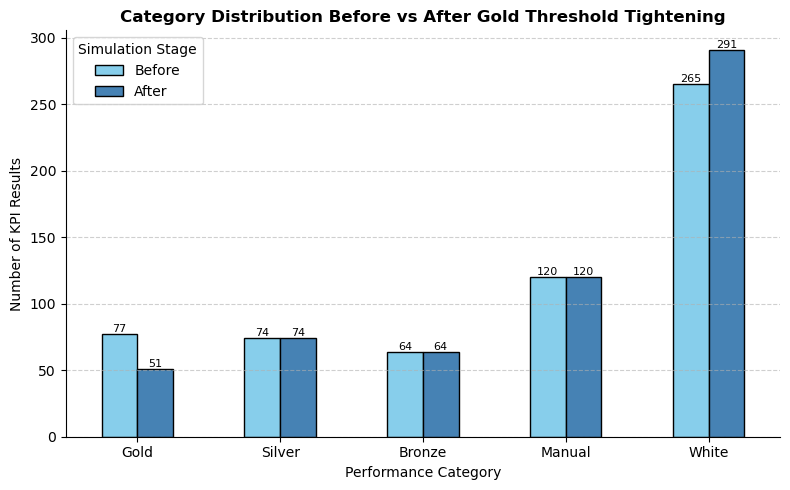

In [26]:
# Count category distributions before and after
before_counts = merged_data['Assigned_Category'].value_counts().sort_index()
after_counts = simulated_data['Simulated_Category'].value_counts().sort_index()

# Ensure fixed category order (optional)
ordered_categories = ['Gold', 'Silver', 'Bronze', 'Manual', 'White']
before_counts = before_counts.reindex(ordered_categories)
after_counts = after_counts.reindex(ordered_categories)

# Combine into a DataFrame
threshold_shift = pd.DataFrame({'Before': before_counts, 'After': after_counts})

# Plot grouped bar chart
ax = threshold_shift.plot(
    kind='bar',
    figsize=(8, 5),
    color=['skyblue', 'steelblue'],
    edgecolor='black'
)

# Add value labels
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', label_type='edge', fontsize=8)

# Styling
plt.title("Category Distribution Before vs After Gold Threshold Tightening", fontsize=12, weight='bold')
plt.xlabel("Performance Category")
plt.ylabel("Number of KPI Results")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# ✅ Updated legend position (moved to the left to avoid overlap)
plt.legend(title="Simulation Stage", loc='upper left', bbox_to_anchor=(0, 1))

# Clean up border
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

##  Simulation 2: Impact of a 3-Point Drop in KPI Values

This simulation models a real-world decline in performance due to external pressures such as staffing shortages, seasonal strain, or operational disruption.

**Objective**:
To assess how a uniform 3-point reduction in all KPI values would affect category assignments, helping identify:
- Wards or KPIs most sensitive to performance drops
- Risk exposure if current performance slips
- Potential loss of Gold status under slight underperformance

The results compare original vs drop-influenced category classifications.


In [15]:
# Step 1: Create a new copy from the merged dataset
value_drop_sim = merged_data.copy()

# Step 2: Simulate a 3-point drop in KPI values
value_drop_sim['KPI_Value'] = value_drop_sim['KPI_Value'] - 3

# Step 3: Re-apply categorisation logic to the modified dataset
value_drop_sim['Drop_Category'] = value_drop_sim.apply(assign_category, axis=1)

# Step 4: Compare original vs drop simulation
drop_comparison = value_drop_sim[['Ward', 'KPI_Name', 'Month', 'KPI_Value', 'Assigned_Category', 'Drop_Category']].copy()
drop_comparison['Changed'] = drop_comparison['Assigned_Category'] != drop_comparison['Drop_Category']

# Step 5: Display sample of category shifts
print("Value Drop Simulation Comparison:")
display(drop_comparison.head(10))

Value Drop Simulation Comparison:


,Ward,KPI_Name,Month,KPI_Value,Assigned_Category,Drop_Category,Changed
0,Stroke Unit,Hand Hygiene Compliance,Jan,85.6,Bronze,Bronze,False
1,Stroke Unit,Hand Hygiene Compliance,Feb,96.7,Gold,Gold,False
2,Stroke Unit,Hand Hygiene Compliance,Mar,92.9,Gold,Silver,True
3,Stroke Unit,Hand Hygiene Compliance,Apr,82.1,Bronze,White,True
4,Stroke Unit,Hand Hygiene Compliance,May,92.8,Gold,Silver,True
5,Stroke Unit,Hand Hygiene Compliance,Jun,94.7,Gold,White,True
6,Stroke Unit,Hand Hygiene Compliance,Jul,90.8,Silver,Silver,False
7,Stroke Unit,Hand Hygiene Compliance,Aug,97.0,Gold,Gold,False
8,Stroke Unit,Hand Hygiene Compliance,Sep,84.9,Bronze,White,True
9,Stroke Unit,Hand Hygiene Compliance,Oct,82.2,Bronze,White,True


### Summary of Simulation-2 Impact

The following tables break down the results of the 3-point drop simulation:

- **Table 1**: Number of category shifts by Ward and KPI — helps identify sensitive indicators or vulnerable areas.
- **Table 2**: Overall count of changed vs unchanged KPI results — provides a quick understanding of performance stability.


In [16]:
# Count how many rows changed per Ward and KPI
change_summary = drop_comparison.groupby(['Ward', 'KPI_Name'])['Changed'].sum().reset_index()
change_summary = change_summary.rename(columns={'Changed': 'Count_Changed'})

print("Table1:Summary of KPI category changes per Ward:")
display(change_summary)

Table1:Summary of KPI category changes per Ward:


,Ward,KPI_Name,Count_Changed
0,Emergency Assessment Unit [EAU],Concerns Logged,0
1,Emergency Assessment Unit [EAU],Falls per 1000 Bed Days,8
2,Emergency Assessment Unit [EAU],Hand Hygiene Compliance,7
3,Emergency Assessment Unit [EAU],Record Keeping Compliance,8
4,Emergency Assessment Unit [EAU],Violence and Aggression Incidents,2
5,Short Stay Unit [SSU],Concerns Logged,0
6,Short Stay Unit [SSU],Falls per 1000 Bed Days,6
7,Short Stay Unit [SSU],Hand Hygiene Compliance,8
8,Short Stay Unit [SSU],Record Keeping Compliance,9
9,Short Stay Unit [SSU],Violence and Aggression Incidents,0


In [17]:
# Total number of changed vs unchanged rows
overall_impact = drop_comparison['Changed'].value_counts().reset_index()
overall_impact.columns = ['Changed', 'Count']

print("Table 2: Overall Change Summary:")
display(overall_impact)

Table 2: Overall Change Summary:


,Changed,Count
0,False,348
1,True,252


In [18]:
# Summary of total changes caused by performance drop
drop_impact = drop_comparison['Changed'].sum()
total_records = drop_comparison.shape[0]
drop_rate = (drop_impact / total_records) * 100

print(f"\nTotal KPIs affected by 3-point drop: {drop_impact} out of {total_records} ({drop_rate:.1f}%)")


Total KPIs affected by 3-point drop: 252 out of 600 (42.0%)


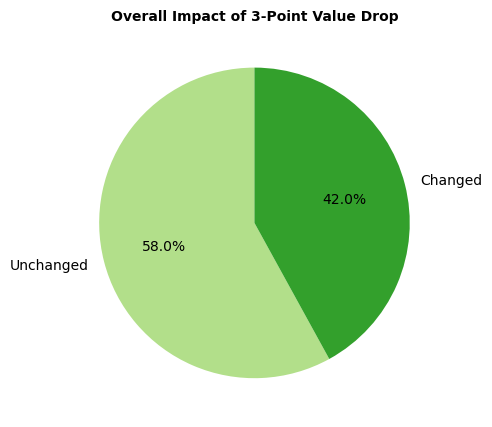

In [22]:
# Count Changed vs Unchanged rows
change_counts = drop_comparison['Changed'].value_counts()
labels = ['Unchanged', 'Changed']
colors = ['#b2df8a', '#33a02c']  # Green tones

# Plot pie chart
plt.figure(figsize=(5, 5))
plt.pie(
    change_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

plt.title('Overall Impact of 3-Point Value Drop', fontsize=10, weight='bold')
plt.tight_layout()
plt.show()

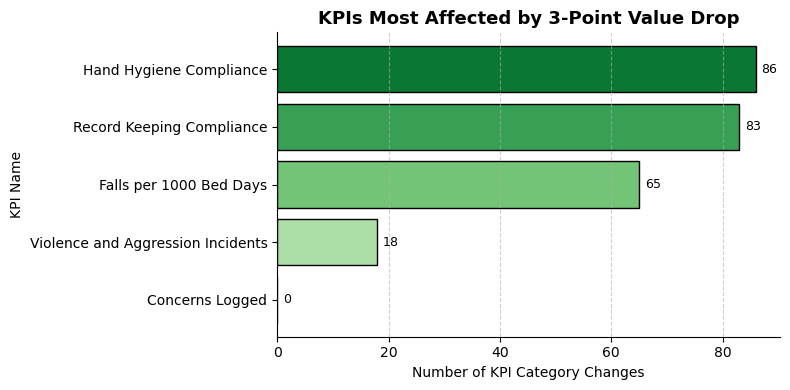

In [27]:
# Sort and reset index
kpi_change_df = drop_comparison.groupby('KPI_Name')['Changed'].sum().sort_values().reset_index()
kpi_change_df.columns = ['KPI_Name', 'Count_Changed']

# Create a green gradient palette
colors = sns.color_palette("Greens", n_colors=len(kpi_change_df))

# Plot
plt.figure(figsize=(8, 4))
bars = plt.barh(
    kpi_change_df['KPI_Name'],
    kpi_change_df['Count_Changed'],
    color=colors,
    edgecolor='black'
)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2, f'{int(width)}', va='center', fontsize=9)

# Styling
plt.title('KPIs Most Affected by 3-Point Value Drop', fontsize=13, weight='bold')
plt.xlabel('Number of KPI Category Changes')
plt.ylabel('KPI Name')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Remove chart frame borders
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()